## Hypothesis validation notebook (TABULAR)

Dataset: `TABULAR` from `DATASET_REGISTRY` (breast cancer; small and local-friendly).

We validate the refined hypothesis on a real dataset:

**Hypothesis (operational):** In representation space $z=\\phi_\\ell(x)$, clean samples exhibit class-conditional local regularity. Adversarial samples are enriched among points showing decision–geometry inconsistency (e.g., class-mixed neighborhoods; atypical for predicted class relative to alternatives).

We keep the attack fixed and vary only detector components aligned with the hypothesis:
- Topology neighborhood semantics: global vs predicted-class restricted
- Local metric conditioning before PH: none vs whiten
- Scoring rule: typicality vs contrastive predicted gap

Outputs include ROC curves, score distributions, neighborhood purity, contrastive gap plots, and PCA of penultimate features.


In [1]:
import pathlib
import sys
import time
from dataclasses import replace

import numpy as np
import matplotlib.pyplot as plt

repo_root = pathlib.Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from src.api import (
    get_dataset,
    get_model,
    train,
    generate_adversarial,
    compute_scores,
    concat_scores,
    fit_detector,
)
from src.evaluation import evaluate_detector
from src.models import get_model_predictions, extract_features_batch
from src.utils import ExperimentConfig, DataConfig, ModelConfig, AttackConfig, GraphConfig, DetectorConfig
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


### Config (fast)

TABULAR is small, so we can score more points, but PH still has a cost.


In [2]:
SEED = 42
MAX_POINTS_FOR_SCORING = 300

cfg_base = ExperimentConfig(
    seed=SEED,
    device='cpu',
    data=DataConfig(train_ratio=0.6, val_ratio=0.2, test_ratio=0.2),
    model=ModelConfig(epochs=60, batch_size=64, learning_rate=1e-3, weight_decay=1e-4),
    attack=AttackConfig(attack_type='fgsm', epsilon=0.05),
    graph=GraphConfig(
        space='feature',
        feature_layer='penultimate',
        use_topology=True,
        topo_k=40,
        topo_preprocess='pca',
        topo_pca_dim=10,
        topo_maxdim=1,
        topo_neighbor_mode='global',
        topo_metric_normalization='none',
        topo_whiten_ridge=1e-3,
        topo_k_list=None,
    ),
    detector=DetectorConfig(
        detector_type='topology_score',
        topo_percentile=95.0,
        topo_cov_shrinkage=1e-3,
        topo_class_conditional=False,
        topo_class_scoring_mode='min_over_classes',
        topo_min_clean_per_class=5,
    ),
)
cfg_base


ExperimentConfig(data=DataConfig(n_samples=1000, noise=0.1, random_state=42, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, root='./data', download=False), model=ModelConfig(input_dim=2, hidden_dims=[64, 32], output_dim=2, activation='relu', learning_rate=0.001, epochs=60, batch_size=64, weight_decay=0.0001, random_state=42), attack=AttackConfig(attack_type='fgsm', epsilon=0.05, num_steps=10, step_size=0.01, random_start=True), ood=OODConfig(enabled=False, method='feature_shuffle', severity=1.0, seed=None, batch_size=128, patch_size=4, blur_kernel_size=5, blur_sigma=1.0, saltpepper_p=0.05), graph=GraphConfig(k=10, sigma=None, space='feature', feature_layer='penultimate', normalized_laplacian=True, use_diffusion=False, diffusion_components=10, use_tangent=True, tangent_k=20, tangent_dim=None, tangent_var_threshold=0.9, tangent_dim_min=2, tangent_dim_max=None, use_topology=True, topo_k=40, topo_maxdim=1, topo_metric='euclidean', topo_thresh=None, topo_min_persistence=1e-06, topo_preproc

### Train model once + generate adversarial examples

In [3]:
bundle = get_dataset('TABULAR', cfg_base)
num_classes = int(bundle.meta.get('num_classes', 2))

# MLP is the intended baseline for TABULAR
model = get_model('MLP', cfg_base, input_dim=int(bundle.X_train.shape[1]), output_dim=num_classes)
trained = train(model, bundle, cfg_base, device=cfg_base.device, verbose=True, return_history=False)

X_adv_val = generate_adversarial(trained, bundle.X_val, bundle.y_val, cfg_base, clip=None)
X_adv_test = generate_adversarial(trained, bundle.X_test, bundle.y_test, cfg_base, clip=None)

print('Shapes:', bundle.X_train.shape, bundle.X_val.shape, bundle.X_test.shape)


Epoch [10/60] Train Loss: 0.1066, Train Acc: 97.36%, Val Loss: 0.1312, Val Acc: 93.86%
Epoch [20/60] Train Loss: 0.0460, Train Acc: 99.12%, Val Loss: 0.0729, Val Acc: 97.37%
Epoch [30/60] Train Loss: 0.0303, Train Acc: 99.12%, Val Loss: 0.0652, Val Acc: 97.37%
Epoch [40/60] Train Loss: 0.0296, Train Acc: 99.12%, Val Loss: 0.0646, Val Acc: 97.37%
Early stopping at epoch 43
Shapes: (341, 30) (114, 30) (114, 30)


### Subsample points for PH scoring (runtime control)

In [4]:
rng = np.random.default_rng(SEED)

def _subsample(X, y, n_max: int):
    X = np.asarray(X)
    y = np.asarray(y, dtype=int)
    if len(X) <= n_max:
        return X, y
    idx = rng.choice(np.arange(len(X)), size=int(n_max), replace=False)
    return X[idx], y[idx]

X_val_clean_used, y_val_clean_used = _subsample(bundle.X_val, bundle.y_val, MAX_POINTS_FOR_SCORING)
X_val_adv_used, y_val_adv_used = _subsample(X_adv_val, bundle.y_val, MAX_POINTS_FOR_SCORING)
X_test_clean_used, y_test_clean_used = _subsample(bundle.X_test, bundle.y_test, MAX_POINTS_FOR_SCORING)
X_test_adv_used, y_test_adv_used = _subsample(X_adv_test, bundle.y_test, MAX_POINTS_FOR_SCORING)

print('Val used:', X_val_clean_used.shape, X_val_adv_used.shape)
print('Test used:', X_test_clean_used.shape, X_test_adv_used.shape)


Val used: (114, 30) (114, 30)
Test used: (114, 30) (114, 30)


In [5]:
def _needs_y_pred(det_cfg: DetectorConfig) -> bool:
    if not bool(getattr(det_cfg, 'topo_class_conditional', False)):
        return False
    m = str(getattr(det_cfg, 'topo_class_scoring_mode', 'min_over_classes')).strip().lower()
    return m in {'predicted_class', 'pred', 'contrastive_pred_gap', 'contrastive', 'pred_gap'}


def run_variant(*, name: str, cfg: ExperimentConfig):
    t0 = time.perf_counter()

    scores_val_clean = compute_scores(X_val_clean_used, trained, bundle=bundle, cfg=cfg)
    scores_val_adv = compute_scores(X_val_adv_used, trained, bundle=bundle, cfg=cfg)
    scores_test_clean = compute_scores(X_test_clean_used, trained, bundle=bundle, cfg=cfg)
    scores_test_adv = compute_scores(X_test_adv_used, trained, bundle=bundle, cfg=cfg)

    scores_val_all = concat_scores(scores_val_clean, scores_val_adv)
    any_key = next(iter(scores_val_all.keys()))
    labels_val = np.concatenate([
        np.zeros(len(scores_val_clean[any_key]), dtype=int),
        np.ones(len(scores_val_adv[any_key]), dtype=int)
    ])
    y_val_all = np.concatenate([np.asarray(y_val_clean_used, dtype=int), np.asarray(y_val_adv_used, dtype=int)])

    y_pred_val_all = None
    if _needs_y_pred(cfg.detector):
        y_pred_val_clean = get_model_predictions(trained, np.asarray(X_val_clean_used), device=str(cfg.device), return_probs=False)
        y_pred_val_adv = get_model_predictions(trained, np.asarray(X_val_adv_used), device=str(cfg.device), return_probs=False)
        y_pred_val_all = np.concatenate([np.asarray(y_pred_val_clean, dtype=int), np.asarray(y_pred_val_adv, dtype=int)])

    detector = fit_detector(scores_val_all, labels_val, cfg, y_true=y_val_all, y_pred=y_pred_val_all)

    scores_test_all = concat_scores(scores_test_clean, scores_test_adv)
    any_key_t = next(iter(scores_test_all.keys()))
    labels_test = np.concatenate([
        np.zeros(len(scores_test_clean[any_key_t]), dtype=int),
        np.ones(len(scores_test_adv[any_key_t]), dtype=int)
    ])

    y_pred_test_all = None
    if _needs_y_pred(cfg.detector):
        y_pred_test_clean = get_model_predictions(trained, np.asarray(X_test_clean_used), device=str(cfg.device), return_probs=False)
        y_pred_test_adv = get_model_predictions(trained, np.asarray(X_test_adv_used), device=str(cfg.device), return_probs=False)
        y_pred_test_all = np.concatenate([np.asarray(y_pred_test_clean, dtype=int), np.asarray(y_pred_test_adv, dtype=int)])

    try:
        raw_scores_test = detector.score(scores_test_all, y_pred=y_pred_test_all)
    except TypeError:
        raw_scores_test = detector.score(scores_test_all)

    thr = float(getattr(detector, 'threshold', np.nan))
    metrics = evaluate_detector(np.asarray(labels_test, dtype=int), np.asarray(raw_scores_test, dtype=float), threshold=thr)
    wall = time.perf_counter() - t0

    return {
        'name': str(name),
        'cfg': cfg,
        'detector': detector,
        'scores_test_all': scores_test_all,
        'labels_test': labels_test,
        'raw_scores_test': np.asarray(raw_scores_test, dtype=float),
        'threshold': thr,
        'metrics': metrics,
        'wall_s': float(wall),
        'y_pred_test_all': y_pred_test_all,
    }


### Variants (same as synthetic notebook)

- V0: pooled/global
- V1: class-conditional typicality
- V2: decision-aware neighborhoods (predicted class)
- V3: V2 + whitening
- V4: V3 + contrastive gap scoring


In [6]:
variants = []
cfg_v0 = cfg_base
variants.append(('V0_pooled_global', cfg_v0))

cfg_v1 = replace(cfg_base, detector=replace(cfg_base.detector, topo_class_conditional=True, topo_class_scoring_mode='min_over_classes'))
variants.append(('V1_classcond_global', cfg_v1))

cfg_v2 = replace(cfg_v1, graph=replace(cfg_v1.graph, topo_neighbor_mode='class_pred'))
variants.append(('V2_classcond_classPredNbr', cfg_v2))

cfg_v3 = replace(cfg_v2, graph=replace(cfg_v2.graph, topo_metric_normalization='whiten', topo_whiten_ridge=1e-3))
variants.append(('V3_classPredNbr_whiten', cfg_v3))

cfg_v4 = replace(cfg_v3, detector=replace(cfg_v3.detector, topo_class_scoring_mode='contrastive_pred_gap'))
variants.append(('V4_contrastive_gap', cfg_v4))

results = []
for name, cfg in variants:
    print('Running', name)
    r = run_variant(name=name, cfg=cfg)
    results.append(r)
    m = r['metrics']
    print('  roc_auc=', m.get('roc_auc'), 'pr_auc=', m.get('pr_auc'), 'fpr@95=', m.get('fpr_at_tpr95'), 'wall_s=', r['wall_s'])

[(r['name'], float(r['metrics']['roc_auc'])) for r in results]


Running V0_pooled_global
  roc_auc= 0.49761465066174204 pr_auc= 0.5020367237416861 fpr@95= 0.9298245614035088 wall_s= 3.7530655420000003
Running V1_classcond_global
  roc_auc= 0.5182363804247461 pr_auc= 0.5061068611921601 fpr@95= 0.9122807017543859 wall_s= 3.183961042000001
Running V2_classcond_classPredNbr
  roc_auc= 0.5133887349953832 pr_auc= 0.5027990818638299 fpr@95= 0.9035087719298246 wall_s= 3.3521421249999985
Running V3_classPredNbr_whiten
  roc_auc= 0.5513234841489689 pr_auc= 0.5484636231162918 fpr@95= 0.9473684210526315 wall_s= 4.011969917000002
Running V4_contrastive_gap
  roc_auc= 0.48230224684518314 pr_auc= 0.4905556152595851 fpr@95= 0.956140350877193 wall_s= 3.6732548750000014


[('V0_pooled_global', 0.49761465066174204),
 ('V1_classcond_global', 0.5182363804247461),
 ('V2_classcond_classPredNbr', 0.5133887349953832),
 ('V3_classPredNbr_whiten', 0.5513234841489689),
 ('V4_contrastive_gap', 0.48230224684518314)]

### ROC curves

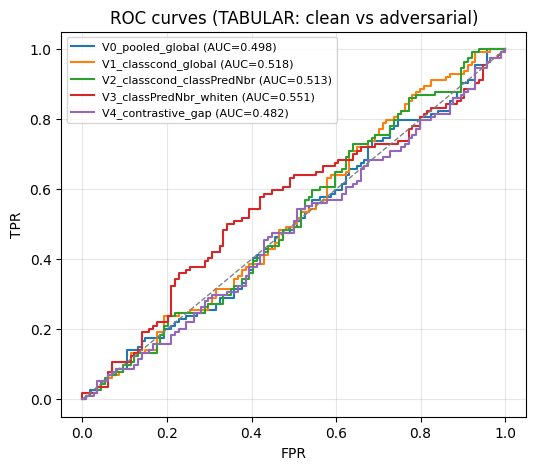

In [7]:
plt.figure(figsize=(6, 5))
for r in results:
    fpr = np.asarray(r['metrics']['fpr'])
    tpr = np.asarray(r['metrics']['tpr'])
    auc = float(r['metrics']['roc_auc'])
    plt.plot(fpr, tpr, label=f"{r['name']} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves (TABULAR: clean vs adversarial)')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()


### Score distributions

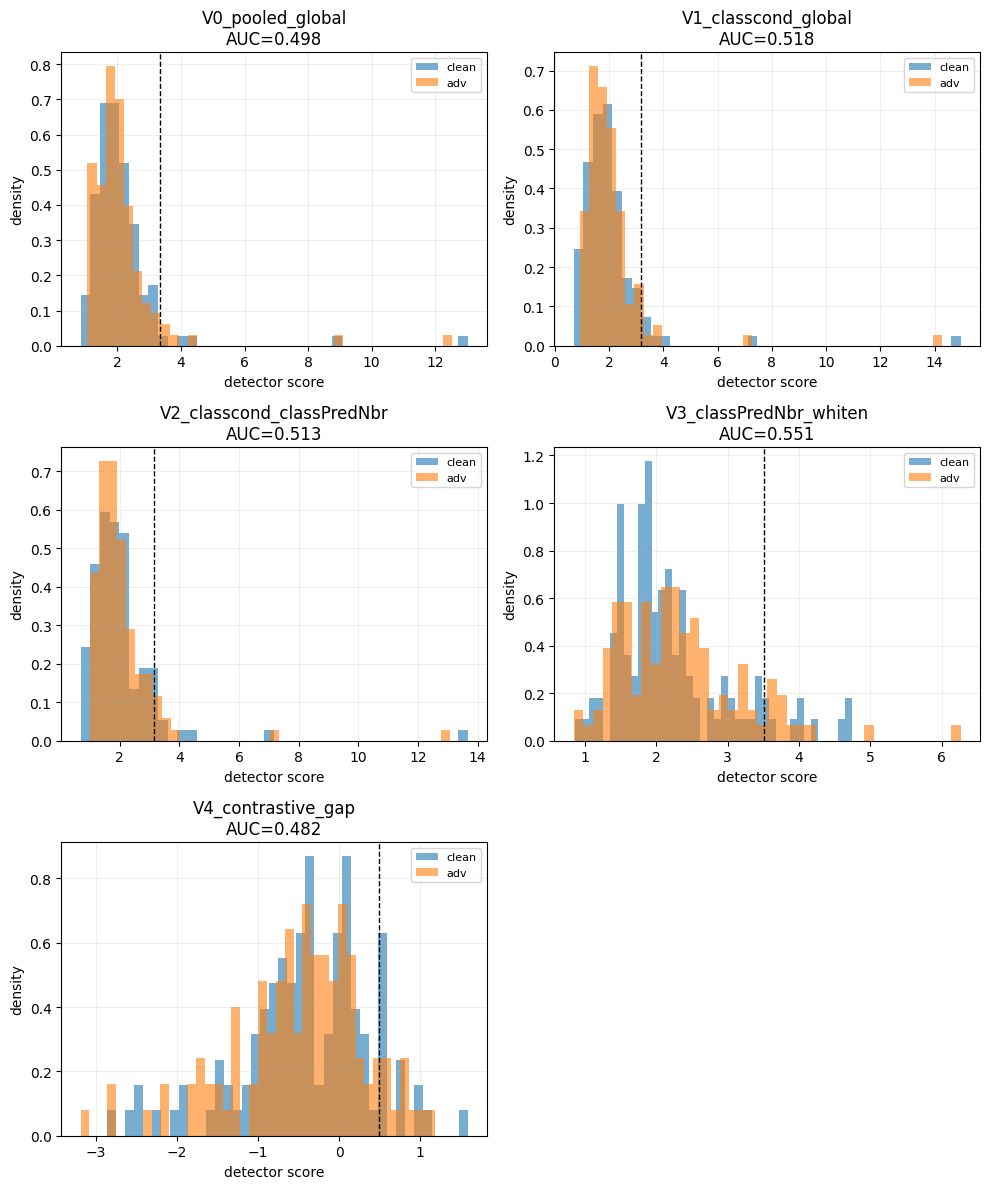

In [8]:
ncols = 2
nrows = int(np.ceil(len(results) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4*nrows), squeeze=False)

for ax, r in zip(axes.ravel(), results):
    y = np.asarray(r['labels_test'], dtype=int)
    s = np.asarray(r['raw_scores_test'], dtype=float)
    thr = float(r['threshold'])
    ax.hist(s[y == 0], bins=40, alpha=0.6, label='clean', density=True)
    ax.hist(s[y == 1], bins=40, alpha=0.6, label='adv', density=True)
    ax.axvline(thr, color='k', linestyle='--', linewidth=1)
    ax.set_title(f"{r['name']}\nAUC={float(r['metrics']['roc_auc']):.3f}")
    ax.set_xlabel('detector score')
    ax.set_ylabel('density')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.2)

for ax in axes.ravel()[len(results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


## Hypothesis diagnostics

### 1) Neighborhood purity (global kNN in representation space)

If adversarial points are boundary-adjacent / class-mixed, purity should drop on adv.


purity mean±std
  clean: 0.9629385964912281 ± 0.13004016148109845
  adv  : 0.9478070175438597 ± 0.13913743534960804


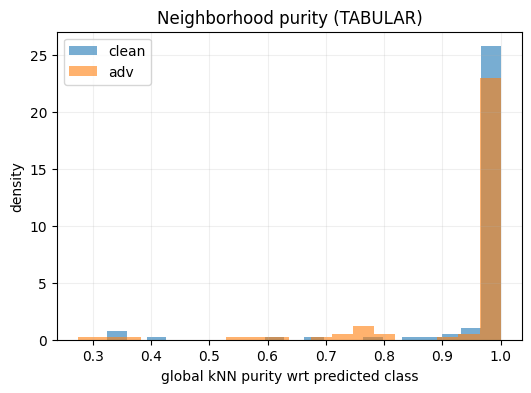

In [9]:
Z_train = extract_features_batch(trained, bundle.X_train, layer=str(cfg_base.graph.feature_layer), device=str(cfg_base.device))
y_train = np.asarray(bundle.y_train, dtype=int)

X_test_all = np.concatenate([X_test_clean_used, X_test_adv_used], axis=0)
y_type = np.concatenate([np.zeros(len(X_test_clean_used), dtype=int), np.ones(len(X_test_adv_used), dtype=int)])
Z_test_all = extract_features_batch(trained, X_test_all, layer=str(cfg_base.graph.feature_layer), device=str(cfg_base.device))
y_pred_test_all = get_model_predictions(trained, X_test_all, device=str(cfg_base.device), return_probs=False).astype(int)

K = int(cfg_base.graph.topo_k)
nbrs = NearestNeighbors(n_neighbors=min(K, len(Z_train)), metric='euclidean').fit(Z_train)
_, idx = nbrs.kneighbors(Z_test_all)
neigh_labels = y_train[idx]
purity_pred = (neigh_labels == y_pred_test_all.reshape(-1, 1)).mean(axis=1)

pur_clean = purity_pred[y_type == 0]
pur_adv = purity_pred[y_type == 1]
print('purity mean±std')
print('  clean:', float(pur_clean.mean()), '±', float(pur_clean.std()))
print('  adv  :', float(pur_adv.mean()), '±', float(pur_adv.std()))

plt.figure(figsize=(6, 4))
plt.hist(pur_clean, bins=20, alpha=0.6, density=True, label='clean')
plt.hist(pur_adv, bins=20, alpha=0.6, density=True, label='adv')
plt.xlabel('global kNN purity wrt predicted class')
plt.ylabel('density')
plt.title('Neighborhood purity (TABULAR)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


### 2) PCA of penultimate features (clean vs adv)

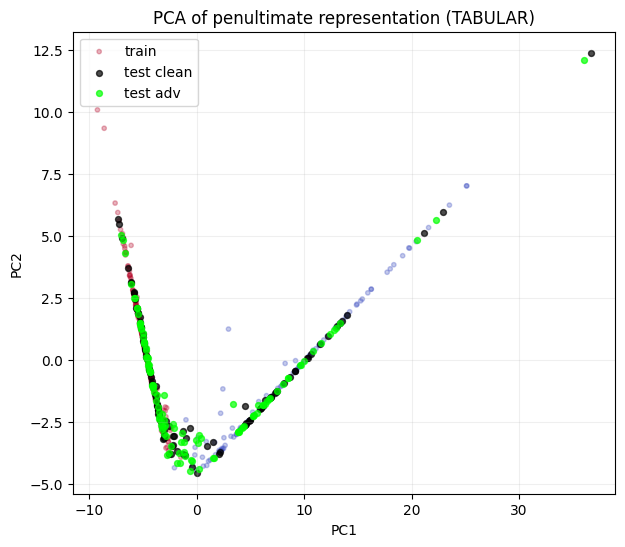

In [10]:
pca2 = PCA(n_components=2, random_state=SEED)
Z2_train = pca2.fit_transform(Z_train)
Z2_test = pca2.transform(Z_test_all)

plt.figure(figsize=(7, 6))
plt.scatter(Z2_train[:,0], Z2_train[:,1], c=y_train, s=10, alpha=0.3, cmap='coolwarm', label='train')
plt.scatter(Z2_test[y_type==0,0], Z2_test[y_type==0,1], c='k', s=18, alpha=0.7, label='test clean')
plt.scatter(Z2_test[y_type==1,0], Z2_test[y_type==1,1], c='lime', s=18, alpha=0.7, label='test adv')
plt.title('PCA of penultimate representation (TABULAR)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()
